In [1]:
%matplotlib inline
import numpy as np
from scipy.io import FortranFile
import matplotlib.pyplot as plt
import sys
sys.path.append('./actpols2')
import act_like
import camb

# Overview

The code blocks in this notebook do the following:
* load the ACTPol Season 2 (S2) likelihood
* calculate a set of theoretical temperature, E-mode polarization, and temperature-polarization crosss-spectra (TT, EE and TE, respectively) using CAMB
* pass the theory spectra to the ACTPol likelihood, and return a (log-)likelihood value
* overplot the theory spectra on top of the power spectrum measurements
* make a visualization of the power spectrum covariance matrix used in the likelihood code

## Loading the likelihood
We start by setting the directory containing the ACTPol likelihood data files. The test() function provided in the likelihood code just checks files can all be loaded OK.

In [2]:
data_dir = './actpols2/data/'
act = act_like.ACTPol_s2(data_dir)
act.test()

Expected: 147.747797921459
Found   : 147.747797921460


## Calculating theoretical spectra from CAMB
To call CAMB we need a set of cosmological parameters. For this example we're using:
* $H_0$, the present-day Hubble parameter, in units of km s$^{-1}$ Mpc$^{-1}$ (H0)
* $\Omega_bh^2$, the physical baryon density (ombh2)
* $\Omega_ch^2$, the physical cold dark matter density (omch2)
* $\tau$, the optical depth to reionization (tau)
* $n_s$, the spectral index of primordial scalar fluctuations (ns)
* $A_s$, the amplitude of primordial scalar fluctuations (As)

Changing the values of these input parameters and rerunning this code block will produce different theory spectra that can be compared with the ACTPol data using the plotting blocks below. The default parameters were taken from the CAMB tutorial and roughly match <i>Planck</i> $\Lambda$CDM best-fit values.

More information about the CAMB function calls can be found in the CAMB demo notebook here: http://camb.readthedocs.io/en/latest/CAMBdemo.html. Note that for high-resolution CMB data sets like ACTPol we go up to multipole $\ell=6000$ and turn up the accuracy of the lensing calculation.

In [3]:
H0 = 67.5    
ombh2 = 0.022
omch2 = 0.122
tau = 0.06
ns = 0.965
As = 2.5e-09

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0.06, omk=0, tau=tau)
pars.InitPower.set_params(ns=ns, r=0, As=As)
pars.set_for_lmax(6000, lens_potential_accuracy=2);

results = camb.get_results(pars)

powers = results.get_cmb_power_spectra(pars)

totCL = powers['total']

## Evaluating the log-likelihood
When calling the ACTPol likelihood we have to be careful about ordering of $C_{\ell}$ arrays - the ACTPol likelihood code expects TT, then TE, then EE. Similarly we need to change the units with factors of $10^{12}$ and $2\pi$. The final argument passed to the likelihood is a polarization angle nuisance parameter (see Louis <i>et al.</i> 2016, https://arxiv.org/abs/1610.02360).

The ACTPol likelihood first bins the theory spectra to make binned bandpowers $C_b^{\rm theory}$ using

$C_b^{\rm theory}=\sum_{\ell\in b}B_{b\ell}C_{\ell}^{\rm theory}$,

where $B_{b\ell}$ are the ACTPol binning matrices provided in the data directory, and then evaluates the negative log-likelihood as

$-\log\mathcal{L}=\frac{1}{2}\sum_{bb'}(C_b-C_b^{\rm theory})\Lambda_{bb'}(C_{b'}-C_{b'}^{\rm theory})$,

where $\Lambda_{bb'}=Cov_{bb'}^{-1}$ is the inverse bandpower covariance matrix, and the sums over $b$ and $b'$ here runs across all the TT, TE, and EE bandpowers. It is assumed that the dependence of the bandpower covariance matrix on the theoretical power spectrum is small and can be neglected. The polarization angle parameter does however rescale the polarization blocks of the covariance matrix.

We finally multiply the negative log-likelihood returned by loglike() by a factor of two to give a $\chi^2$.

In [4]:
negloglike = act.loglike(totCL[2:6001,0]*1e12*2*np.pi, totCL[2:6001,3]*1e12*2*np.pi, totCL[2:6001,1]*1e12*2*np.pi, 0.98)
print 2*negloglike

148.897856085


## Plotting the ACTPol bandpowers and theory spectra

We first load the ACTPol power spectra and error bars. To compare with theory spectra in the usual $\ell(\ell+1)C_{\ell}/2\pi$ plots here we have just multiplied each bandpower by $\ell_b(\ell_b+1)/2\pi$, where $\ell_b$ is the midpoint of each bin.

In [5]:
# Plot the ACTPol bandpowers and theory spectra

nbin = 132   # total number of bins across TT, TE and EE spectra
nbintt = 42  # multipoles 500-4000
nbinte = 45  # multipoles 250-4000
nbinee = 45  # multipoles 250-4000
like_file = data_dir + '/cl_cmb_aps2.dat'
bval, X_data, X_sig = np.genfromtxt(like_file, max_rows=nbin, delimiter = None, unpack=True)

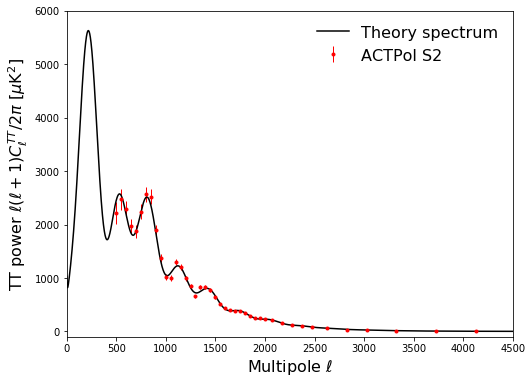

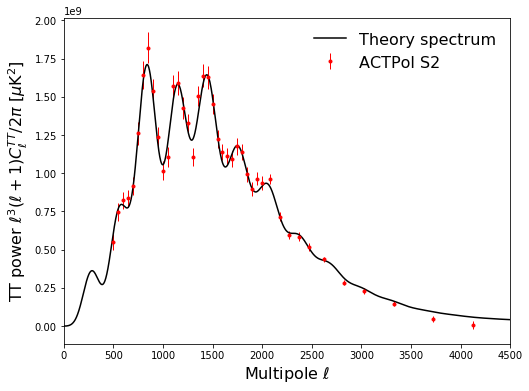

In [6]:
# Temperature (TT) power spectra

# showing l(l+1)Cl
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(2,6001), totCL[2:6001,0]*1e12*2*np.pi, 'k', label='Theory spectrum')
plt.errorbar(bval[:nbintt], bval[:nbintt]*(bval[:nbintt]+1)*X_data[:nbintt]*0.5/np.pi, \
             bval[:nbintt]*(bval[:nbintt]+1)*X_sig[:nbintt]*0.5/np.pi, marker='.', ls='None', c='r', lw=1, \
             label='ACTPol S2')
plt.xlim([0, 4500])
plt.ylim([-100, 6000])
plt.xlabel(r'Multipole $\ell$', size=16)
plt.ylabel(r'TT power $\ell(\ell+1)C_{\ell}^{TT}/2\pi$ [$\mu$K$^2$]', size=16)
plt.legend(frameon=0, numpoints=1, fontsize=16)
plt.show()

# showing l^3(l+1)Cl to enchance damping tail
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(2,6001), np.arange(2,6001)**2*totCL[2:6001,0]*1e12*2*np.pi, 'k', label='Theory spectrum')
plt.errorbar(bval[:nbintt], bval[:nbintt]**3*(bval[:nbintt]+1)*X_data[:nbintt]*0.5/np.pi, \
             bval[:nbintt]**3*(bval[:nbintt]+1)*X_sig[:nbintt]*0.5/np.pi, marker='.', ls='None', c='r', lw=1, \
             label='ACTPol S2')
plt.xlim([0, 4500])
plt.xlabel(r'Multipole $\ell$', size=16)
plt.ylabel(r'TT power $\ell^3(\ell+1)C_{\ell}^{TT}/2\pi$ [$\mu$K$^2$]', size=16)
plt.legend(frameon=0, numpoints=1, fontsize=16)
plt.show()

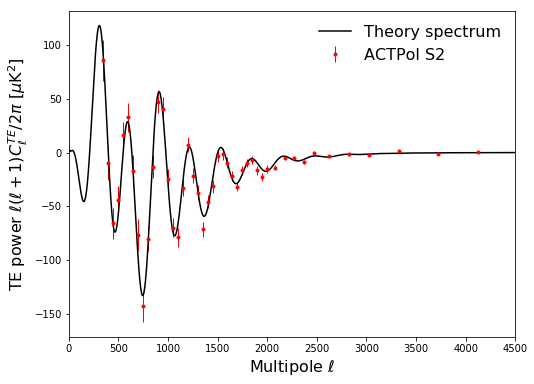

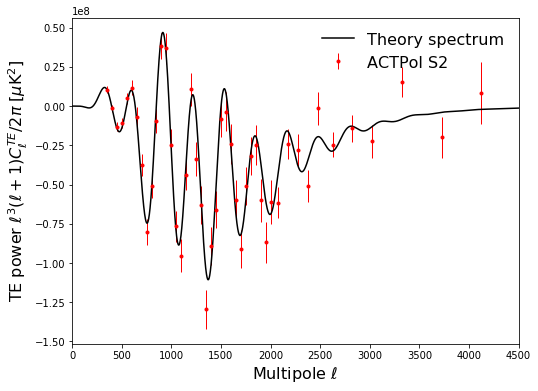

In [7]:
# Temperature-polarization (TE) cross-power spectra

# showing l(l+1)Cl
bins = np.arange(nbintt, nbintt+nbinte)
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(2,6001), totCL[2:6001,3]*1e12*2*np.pi, 'k', label='Theory spectrum')
plt.errorbar(bval[bins], bval[bins]*(bval[bins]+1)*X_data[bins]*0.5/np.pi, \
             bval[bins]*(bval[bins]+1)*X_sig[bins]*0.5/np.pi, marker='.', ls='None', c='r', lw=1, \
             label='ACTPol S2')
plt.xlim([0, 4500])
plt.xlabel(r'Multipole $\ell$', size=16)
plt.ylabel(r'TE power $\ell(\ell+1)C_{\ell}^{TE}/2\pi$ [$\mu$K$^2$]', size=16)
plt.legend(frameon=0, numpoints=1, fontsize=16)
plt.show()

# showing l^3(l+1)Cl to enhance damping tail
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(2,6001), np.arange(2,6001)**2*totCL[2:6001,3]*1e12*2*np.pi, 'k', label='Theory spectrum')
plt.errorbar(bval[bins], bval[bins]**3*(bval[bins]+1)*X_data[bins]*0.5/np.pi, \
             bval[bins]**3*(bval[bins]+1)*X_sig[bins]*0.5/np.pi, marker='.', ls='None', c='r', lw=1, \
             label='ACTPol S2')
plt.xlim([0, 4500])
plt.xlabel(r'Multipole $\ell$', size=16)
plt.ylabel(r'TE power $\ell^3(\ell+1)C_{\ell}^{TE}/2\pi$ [$\mu$K$^2$]', size=16)
plt.legend(frameon=0, numpoints=1, fontsize=16)
plt.show()

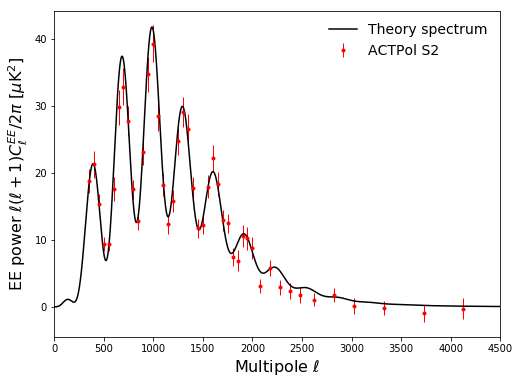

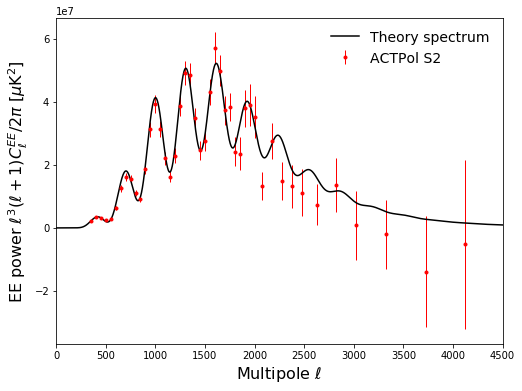

In [8]:
# E-mode polarization (EE) power spectra

# showing l(l+1)Cl
bins = np.arange(nbintt+nbinte, nbin)
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(2,6001), totCL[2:6001,1]*1e12*2*np.pi, 'k', label='Theory spectrum')
plt.errorbar(bval[bins], bval[bins]*(bval[bins]+1)*X_data[bins]*0.5/np.pi, \
             bval[bins]*(bval[bins]+1)*X_sig[bins]*0.5/np.pi, marker='.', ls='None', c='r', lw=1, \
             label='ACTPol S2')
plt.xlim([0, 4500])
plt.xlabel(r'Multipole $\ell$', size=16)
plt.ylabel(r'EE power $\ell(\ell+1)C_{\ell}^{EE}/2\pi$ [$\mu$K$^2$]', size=16)
plt.legend(frameon=0, numpoints=1, fontsize=14)
plt.show()

# showing l^3(l+1)Cl to enhance damping tail
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(2,6001), np.arange(2,6001)**2*totCL[2:6001,1]*1e12*2*np.pi, 'k', label='Theory spectrum')
plt.errorbar(bval[bins], bval[bins]**3*(bval[bins]+1)*X_data[bins]*0.5/np.pi, \
             bval[bins]**3*(bval[bins]+1)*X_sig[bins]*0.5/np.pi, marker='.', ls='None', c='r', lw=1, \
             label='ACTPol S2')
plt.xlim([0, 4500])
plt.xlabel(r'Multipole $\ell$', size=16)
plt.ylabel(r'EE power $\ell^3(\ell+1)C_{\ell}^{EE}/2\pi$ [$\mu$K$^2$]', size=16)
plt.legend(frameon=0, numpoints=1, fontsize=14)
plt.show()

## Visualizing the ACTPol TT-TE-EE bandpower covariance matrix

The covariance matrix used in the ACTPol likelihood contains diagonal blocks for the TT, TE, and EE spectra, and off-diagonal blocks for the correlation between the different spectra. The code below produces a correlation matrix plot to illustrate some of the off-diagonal structure, which is due to several factors:
* The block diagonal contributions, which are strongest between TT and TE and also TE and EE, and feature both positive and negative correlations, are due to correlated sample variance in the maps. Below are analytic expressions for the sample variance correlations on the full sky. Note that $C_{\ell}^{TE}$ oscillates around zero (see plots above). Instrumental noise correlations are also included in the matrix.
    - $cov^{TT-TT}_{\ell}=\frac{2}{2\ell+1}(C_{\ell}^{TT})^2$
    - $cov^{TT-TE}_{\ell}=\frac{2}{2\ell+1}C_{\ell}^{TT}C_{\ell}^{TE}$
    - $cov^{TT-EE}_{\ell}=\frac{2}{2\ell+1}(C_{\ell}^{TE})^2$
    - $cov^{TE-TE}_{\ell}=\frac{1}{2\ell+1}((C_{\ell}^{TE})^2+C_{\ell}^{TT}C_{\ell}^{EE})$
    - $cov^{TE-EE}_{\ell}=\frac{2}{2\ell+1}C_{\ell}^{TE}C_{\ell}^{EE}$
    - $cov^{EE-EE}_{\ell}=\frac{2}{2\ell+1}(C_{\ell}^{EE})^2$
    
* Mode-coupling due to the mask applied to the map (e.g. to remove bright, resolved point sources) leads to off-diagonal structure within each block of the matrix.

* The stronger positive correlation between the highest bins in the TT-TT block is partly due to foreground removal. Uncertainty in the foreground amplitudes leads to correlated uncertainties in the foreground-cleaned spectra.

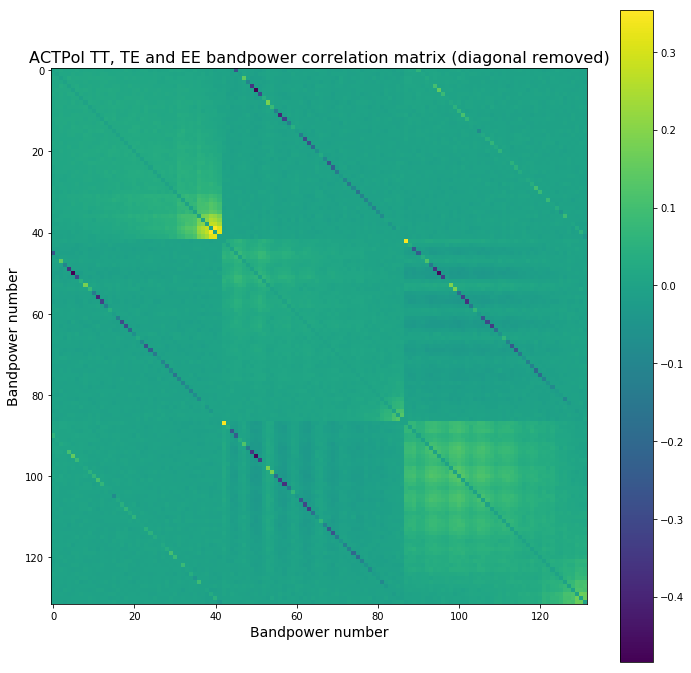

In [9]:
nbin = 132
cov_file = data_dir + '/c_matrix_actpol.dat'
f = FortranFile(cov_file, 'r')
covmat = f.read_reals(dtype=float).reshape((nbin,nbin))
for i_index in range(nbin):
    for j_index in range(i_index, nbin):
        covmat[i_index,j_index] = covmat[j_index,i_index]

# convert from covariance to correlation matrix so we can see off-diagonal structure more easily
temp = np.diag(1/np.sqrt(np.diag(covmat)))
corrmat = np.dot(temp, np.dot(covmat, temp))

# show correlation matrix with the diagonal removed
fig = plt.figure(figsize=(12,12))
plt.imshow(corrmat-np.eye(nbin), interpolation='Nearest')
plt.colorbar()
plt.xlabel("Bandpower number", size=14)
plt.ylabel("Bandpower number", size=14)
plt.title("ACTPol TT, TE and EE bandpower correlation matrix (diagonal removed)", size=16)
plt.show()